In [1]:
%matplotlib inline

In [2]:
import matplotlib.pyplot as plt
import numpy as np
import scipy.interpolate
import os

In [3]:
from adapt_utils.case_studies.tohoku.options import TohokuOptions

# Gauge data for Tohoku tsunami

We have two different types of gauge: GPS gauges and pressure gauges.
In the former case, the observed variable is free surface displacement.
In the latter case, the observed variable is pressure.

We deduce free surface elevation from pressure using hydrostatic assumptions:

$$p_{\mathrm{hydrostatic}}=\rho gh,$$

where $\rho\approx1030.0\,\mathrm{kg\,m}^{-3}$ is the density of sea water, $g\approx9.81\,\mathrm{m\,s}^{-2}$ is gravitational acceleration and $H$ is the height of the fluid column.

The height of the fluid column may be decomposed as

$$H=b + \eta,$$

where the bathymetry $b$ $[\mathrm m]$ is known and $\eta$ is the free surface displacement we seek.

_[These calculations are performed using_ `preproc.py`, _which outputs the_ `.dat` _files.]_

## <u> The data </u>

First let's take a look at what the data looks like once it has been converted into appropriate units. We categorise the gauges based on their distance from the earthquake epicentre.

In [4]:
op = TohokuOptions()

In [5]:
def plot_data(gauges):
    n = len(gauges)
    fig, axes = plt.subplots(nrows=n, figsize=(12, n*4))
    for i, gauge in enumerate(gauges):
        axes[i].plot(*op.extract_data(gauge), label=gauge)
        axes[i].set_xlabel("Time [s]")
        axes[i].set_ylabel("Elevation [m]")
        axes[i].legend()

### Near field GPS gauges

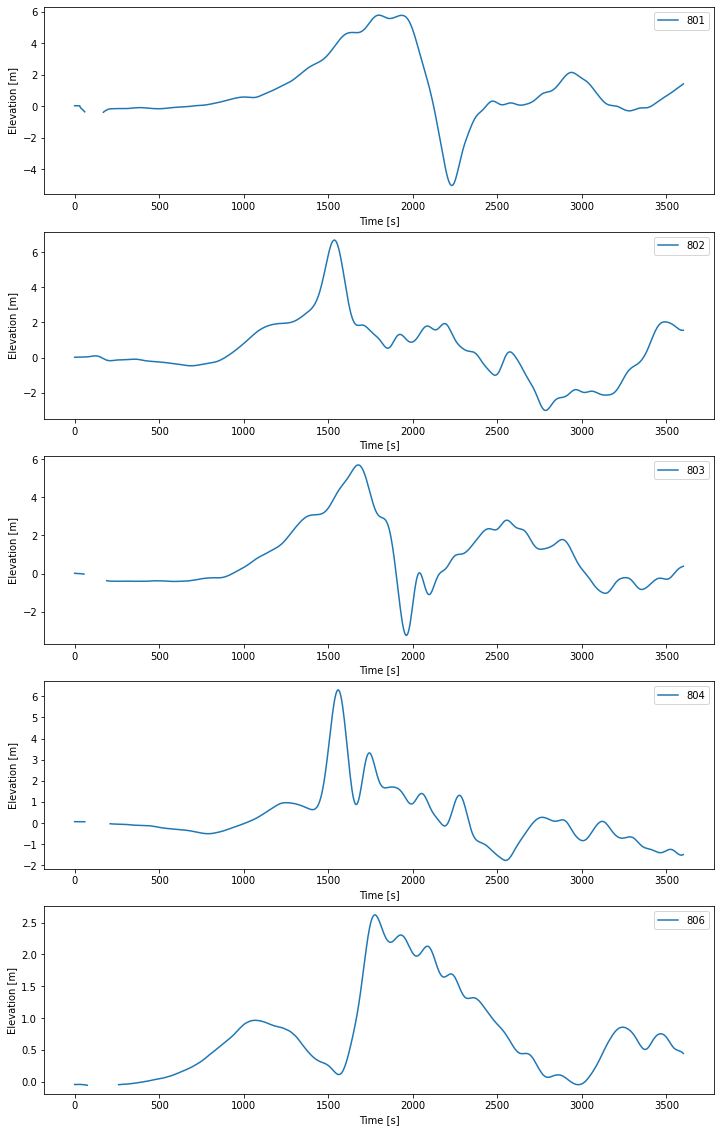

In [6]:
plot_data(op.near_field_gps_gauges["gauges"][:5])  # TODO: consider 807

### Near field pressure gauges

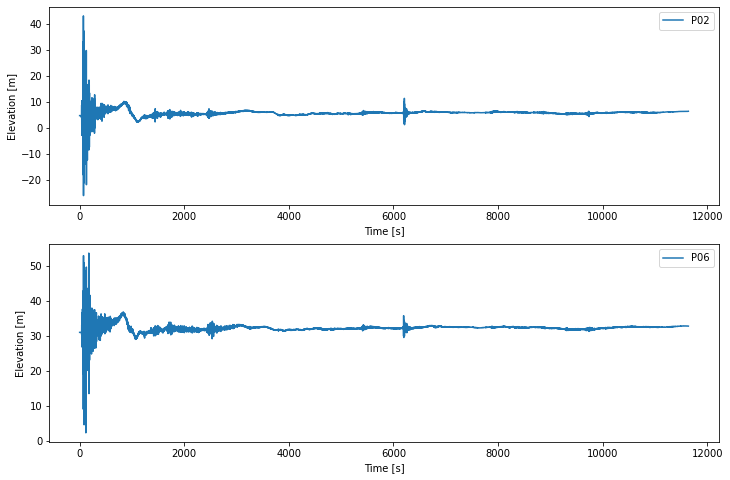

In [6]:
plot_data(op.near_field_pressure_gauges["gauges"])

### Mid field pressure gauges

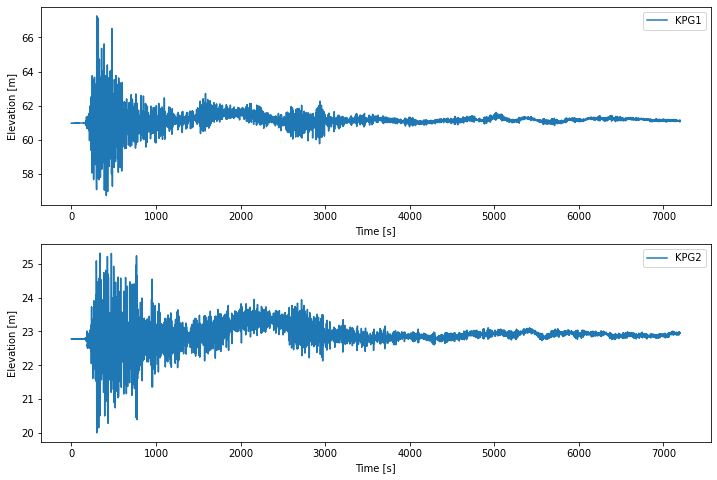

In [8]:
plot_data(op.mid_field_pressure_gauges["gauges"])

### Far field GPS gauges

# [TODO]

### Far field GPS gauges

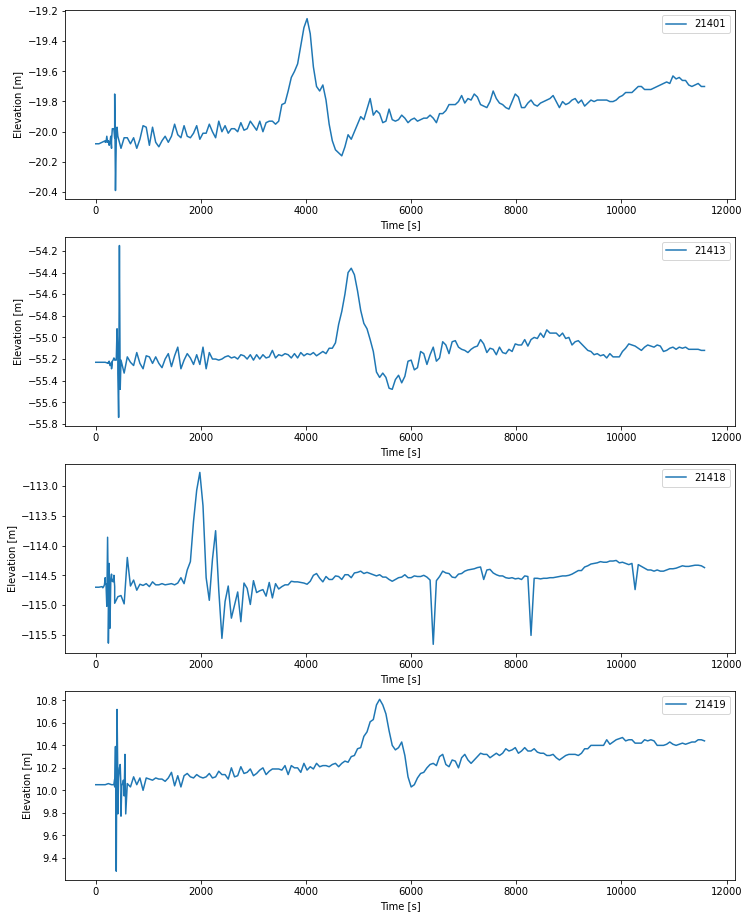

In [13]:
plot_data(op.far_field_pressure_gauges["gauges"])

## <u> Interpolation and sampling </u>

### Far field GPS gauges

# [TODO]

In [6]:
def plot_interpolated_data(gauges, truncate=True, samples=1, plot_data=True, tie_at_start=True):
    n = len(gauges)
    if isinstance(samples, int):
        samples = [samples, ]
    fig, axes = plt.subplots(nrows=n, figsize=(12, n*4))
    for i, gauge in enumerate(gauges):
        ax = axes[i]
        
        # Get data
        times, data = op.extract_data(gauge)

        # Do not consider timeseries before arrival time
        if truncate:
            times = np.array(times[times > op.get_arrival_time(gauge)])
            data = data[-len(times):]
        if tie_at_start:
            data = data - data[0]
        if plot_data:
            ax.plot(times/60, data, label=gauge.upper() + ' data', marker='x', markevery=5)

        for sample in samples:
            
            # Get interpolator
            op.sample_timeseries(gauge, sample=sample)
            interp = op.gauges[gauge]["interpolator"]

            # Assume start value of zero
            op.gauges[gauge]["data"] = np.array([interp(t) for t in times])
            if tie_at_start:
                op.gauges[gauge]["data"] -= op.gauges[gauge]["data"][0]

            # Plot
            label = gauge.upper() + ' interpolant'
            if sample > 1:
                label += ' (sample {:d})'.format(sample)
            ax.plot(times/60, op.gauges[gauge]['data'], label=label)
            
        ax.set_xlabel("Time [min]");
        ax.set_ylabel("Elevation [m]");
        ax.legend(bbox_to_anchor=(1.1, 0.5));
    return axes

### Near field GPS gauges

First consider the data from GPS gauges, each of which is located close to the east coast of Japan.

These data are the cleanest, with only a short sequence of observation errors shortly after the earthquake.
There is no need to sample the data and so we just compute a piecewise linear interpolant which covers the time period with observation errors.

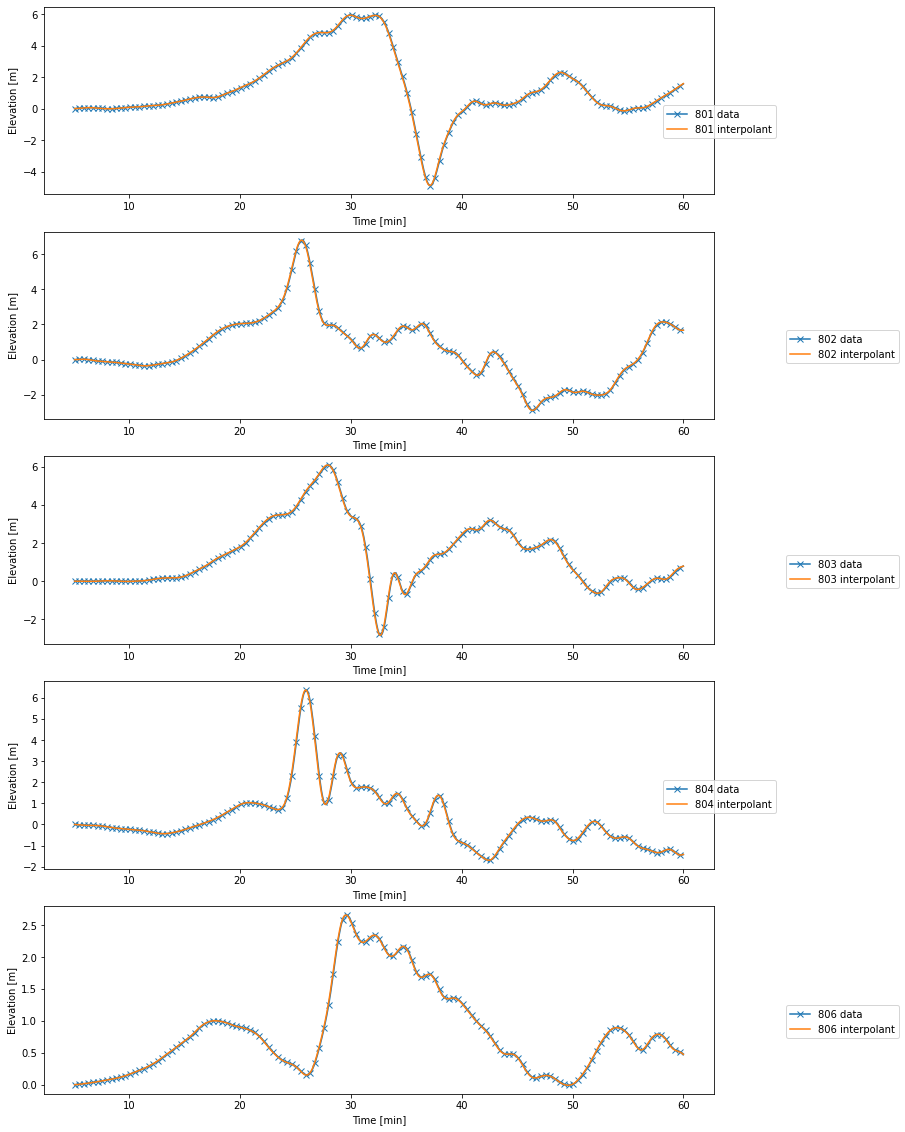

In [11]:
plot_interpolated_data(op.near_field_gps_gauges["gauges"][:5]);  # TODO: consider 807

### Near field pressure gauges

Next consider the temporary pressure gauges P02 and P06 which were operated by Tohoku University.
These gauges were within the tsunami source region and hence registered a significant signal.
We see that there is a lot of noise in this data, likely due to the earthquake which just struck nearby!

From a previous project we also have free surface elevation data extracted from the figure in [Saito et al. 2011] using `PlotDigitizer`.

In [8]:
plot_digitizer = {}
plot_digitizer["P02"] = [
    0.00, 0.07, 0.12, 0.46, 0.85, 1.20, 1.55, 1.90, 2.25, 2.50, 2.80, 3.10, 3.90, 4.80,
    4.46, 2.25, -0.45, -0.17, -1.60, -0.82, -0.44, -0.26, -0.08, 0.13, 0.42, 0.71
]
plot_digitizer["P06"] = [
    0.00, 0.10, 0.30, 0.65, 1.05, 1.35, 1.65, 1.95, 2.25, 2.55, 2.90, 3.50, 4.50, 4.85,
    3.90, 1.55, -0.35, -1.05, -0.65, -0.30, -0.15, 0.05, 0.18, 0.35, 0.53, 0.74
]

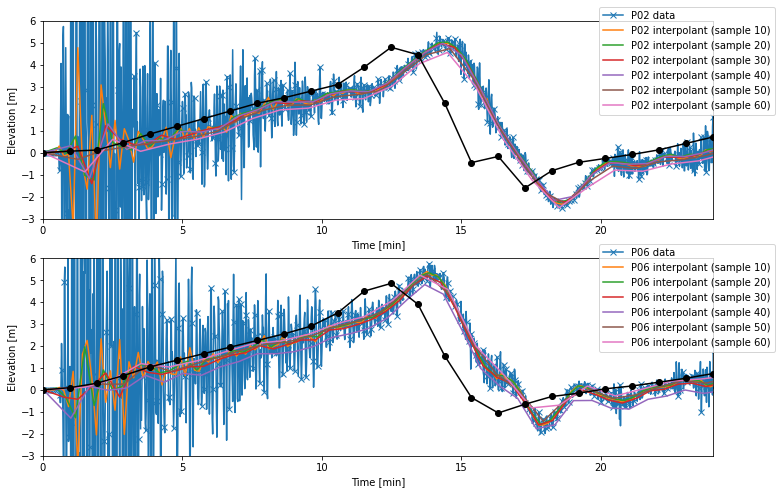

In [9]:
gauges = op.near_field_pressure_gauges["gauges"]
axes = plot_interpolated_data(gauges, samples=[10, 20, 30, 40, 50, 60])
end_time = 24
for ax, gauge in zip(axes, gauges):
    ax.set_xlim([0, end_time])
    ax.set_ylim([-3, 6])
    data = plot_digitizer[gauge]
    N = len(data)
    ax.plot(np.linspace(0, end_time, N), data, marker='o', color='k', label=gauge.title() + ' PlotDigitizer')

It also looks like the converted data and `PlotDigitizer` are out of sync.
Let's try sampling over windows and taking the average for a few different sample sizes and shift the `PlotDigitizer` profile by 90 seconds.

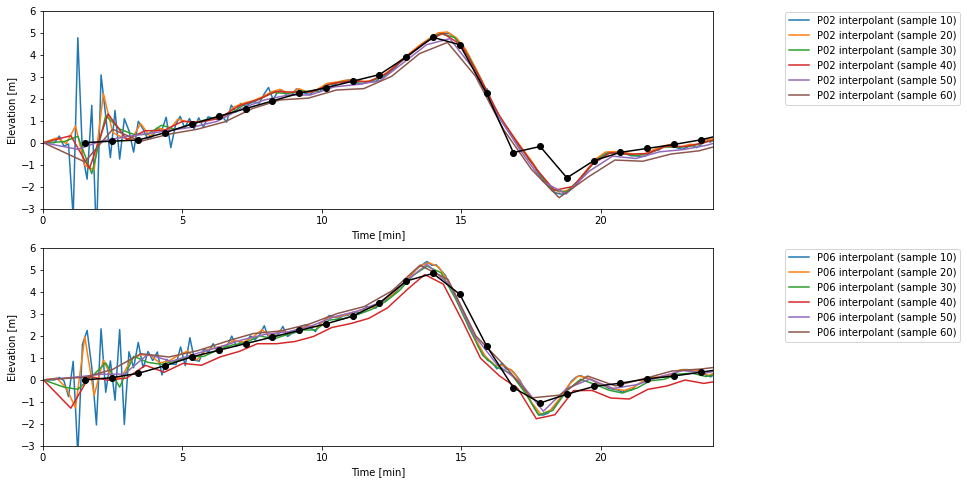

In [10]:
gauges = op.near_field_pressure_gauges["gauges"]
axes = plot_interpolated_data(gauges, samples=[10, 20, 30, 40, 50, 60], plot_data=False, tie_at_start=True)
end_time = 24
for ax, gauge in zip(axes, gauges):
    ax.set_xlim([0, end_time])
    ax.set_ylim([-3, 6])
    data = plot_digitizer[gauge]
    N = len(data)
    ax.plot(np.linspace(0, end_time, N) + 1.5, data, marker='o', color='k', label=gauge.title() + ' PlotDigitizer')

It seems averaging the data over every minute interval is sufficient to reduce the noise to an acceptable level, whilst maintaining the general shape of the profile.

### Mid field pressure gauges

Next consider two gauges to the north of the tsunami source, operated by the Japanese Agency for Marine-Earth Science and Technology (JAMSTEC). 

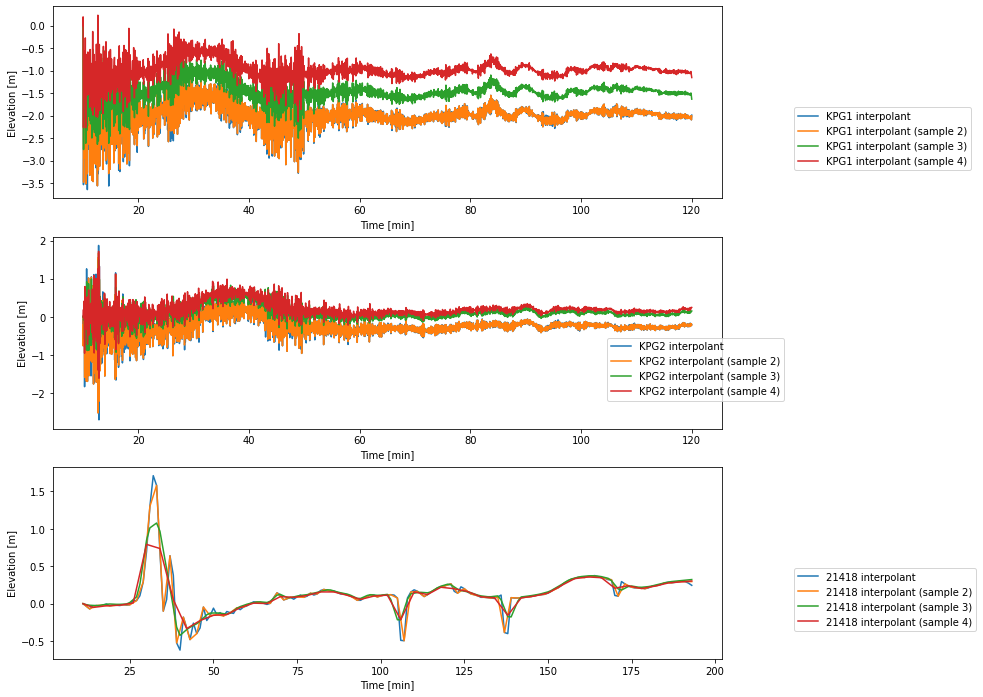

In [16]:
gauges = op.mid_field_pressure_gauges["gauges"]
plot_interpolated_data(gauges, samples=[1, 2, 3, 4], plot_data=False);

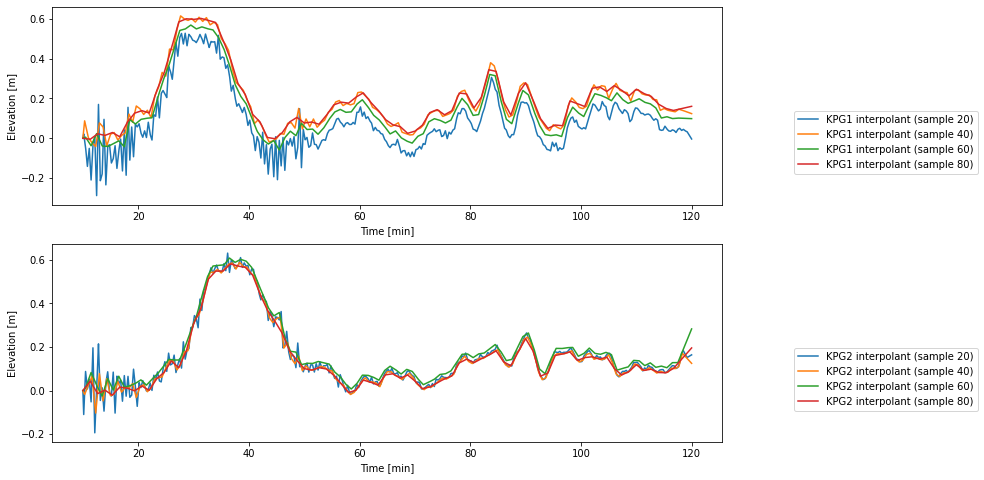

In [9]:
gauges = op.mid_field_pressure_gauges["gauges"][:2]
plot_interpolated_data(gauges, samples=[20, 40, 60, 80], plot_data=False);

### Far field GPS gauges

# [TODO]

### Far field pressure gauges

Finally, there are four DART pressure gauges out in the Pacific which are operated by the US National Oceanic and Atmospheric Administration (NOAA).

Note that the observation frequency is lower for these data so we don't want to do too much sampling.
We choose the arrival time to be after the pulse of the acoustic wave as we don't want to fit to that.

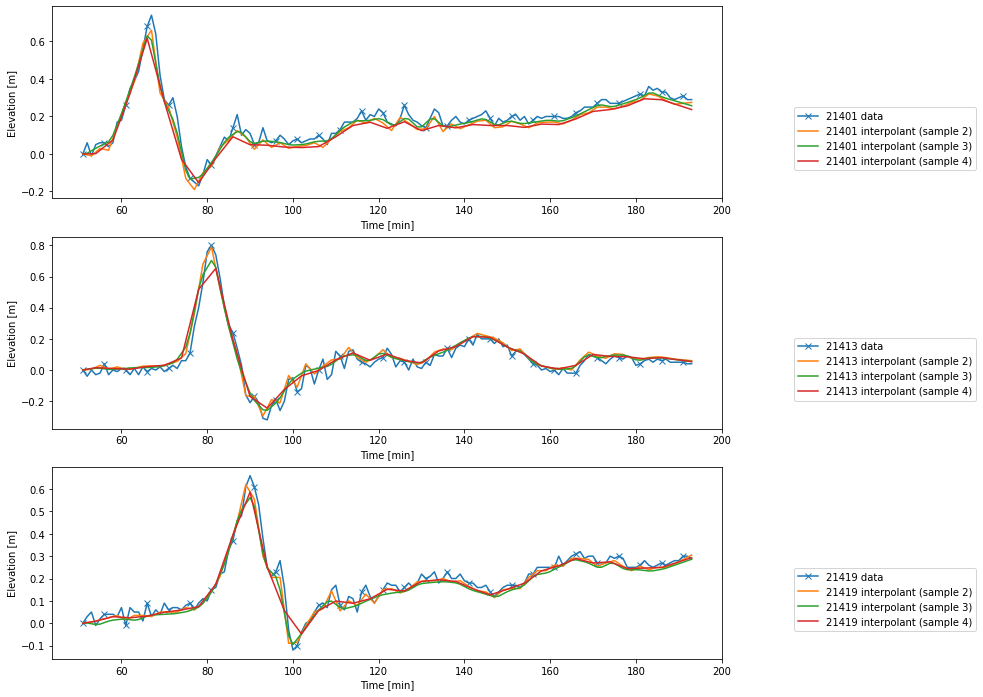

In [7]:
gauges = op.far_field_pressure_gauges["gauges"]
plot_interpolated_data(gauges, samples=[2, 3, 4]);